># Methodologies I
>> ## Modeling
># Part I
>>## (A). Decision Tree Exercises


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import env
import acquire
from prepare import train_validate_test_split, prep_telco, prep_titanic, prep_iris
from prepare import impute_mode

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


# import graphviz
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.linear_model import LogisticRegression




In [29]:
# Call the data
titanic = acquire.get_titanic_data()
titanic.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [21]:
# Describe the data
titanic.describe()

,passenger_id,survived,pclass,age,sibsp,parch,fare,alone
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,445.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.602694
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.489615
min,0.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,222.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,445.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,667.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


### 1). What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [46]:
# Baseline on polulation data

titanic.survived.value_counts()

0    549
1    342
Name: survived, dtype: int64

In [47]:
# Prepare titanic dataset

titanic = prepare.prep_titanic(titanic)

In [48]:
# Split data 
def train_validate_test_split(titanic, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(titanic, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=titanic[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test



In [49]:
train, validate, test = train_validate_test_split(titanic, target = 'survived')
train.shape, validate.shape, test.shape

((498, 10), (214, 10), (179, 10))

In [50]:
train.head()


,sex_male,embark_town_Queenstown,embark_town_Southampton,passenger_id,survived,pclass,sibsp,parch,fare,alone
583,1,0,0,583,0,1,0,0,40.1250,1
165,1,0,1,165,1,3,0,2,20.5250,0
50,1,0,1,50,0,3,4,1,39.6875,0
259,0,0,1,259,1,2,0,1,26.0000,0
306,0,0,0,306,1,1,0,0,110.8833,1


In [51]:
# Drop unnecesary columns 

col_to_drops = ['passenger_id', 'sibsp', 'class', 'embarked', 
                'sex','embark_town','se_male', 'embark_town_Queenstown',
               'embark_town_Southampton'
               ]

[titanic_data.drop(columns = col_to_drops, inplace = True, errors = 'ignore') for titanic_data in [train, validate, test]]

train.head()

,sex_male,survived,pclass,parch,fare,alone
583,1,0,1,0,40.1250,1
165,1,1,3,2,20.5250,0
50,1,0,3,1,39.6875,0
259,0,1,2,1,26.0000,0
306,0,1,1,0,110.8833,1


In [52]:
train.shape

(498, 6)

In [53]:

def clean_dataset(model):
    assert isinstance(model, pd.DataFrame), "df needs to be a pd.DataFrame"
    model.dropna(inplace=True)
    model = model.drop_duplicates()
#     model = pd.DataFrame(model)
    indices_to_keep = ~model.isin([np.nan, np.inf, -np.inf]).any(1)
    return model[indices_to_keep].astype(np.float64)


In [54]:
type(train)

pandas.core.frame.DataFrame

In [55]:
# split into train, validate, test
# train, validate, test = train_validate_test_split(titanic, target='survived', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['survived'])
y_train = train[['survived']]

X_validate = validate.drop(columns=['survived'])
y_validate = validate[['survived']]

X_test = test.drop(columns=['survived'])
y_test = test[['survived']]


> ### Base line train set (survived)
>

In [56]:
train.survived.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [57]:
# Actual baseline (did not survive = 0)

train['baseline'] = 0


# train['baseline'] = train.survived.value_counts().idxmax()
# train.head()



> ### Baseline Accuracy
>

+ve == did not survive (0)

In [58]:
baseline_accuracy = (train.survived == train.baseline).mean()

print(f'\n\tThe training baseline accuracy: {baseline_accuracy}\n')


	The training baseline accuracy: 0.6164658634538153



### 2). Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)


In [59]:
# Create model

clf = DecisionTreeClassifier()

In [60]:
# Fit model

clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [61]:
X = X_train
y = y_train

# Model I Accuracy 
accuracy = clf.score(X, y)

# Model Predictions
y_pred = clf.predict(X)

y_prediction = clf.predict(y, y_pred)

# Classification Report (sklearn.metrics)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict = True)).T

# Using Confusion matrix to compute data
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()

print()
print(f'''  Accuracy: {accuracy:.4%}

            True +ve: {tpr:.3%}
            
            False +ve: {fpr:.3%}
            
            True -ve: {tnr:.3%}
            
            False -ve: {fnr:.3%}
            
        '''
     )

class_report

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### 3). Evaluate your in-sample results using the model score, confusion matrix, and classification report.


In [62]:
# Model prediction 
y_pred = clf.predict(X_train)
y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [63]:
# Model I Accuracy
accuracy = clf.score(X_train, y_train)
accuracy

0.9397590361445783

In [64]:
# Confusion matrix

conf = confusion_matrix(y_train, y_pred)

conf

array([[303,   4],
       [ 26, 165]])

In [65]:
class_report = classification_report(y_train, y_pred, output_dict = True)
class_report

{'0': {'precision': 0.9209726443768997,
  'recall': 0.9869706840390879,
  'f1-score': 0.9528301886792453,
  'support': 307},
 '1': {'precision': 0.9763313609467456,
  'recall': 0.8638743455497382,
  'f1-score': 0.9166666666666667,
  'support': 191},
 'accuracy': 0.9397590361445783,
 'macro avg': {'precision': 0.9486520026618226,
  'recall': 0.9254225147944131,
  'f1-score': 0.9347484276729561,
  'support': 498},
 'weighted avg': {'precision': 0.9422046019368205,
  'recall': 0.9397590361445783,
  'f1-score': 0.9389602434896821,
  'support': 498}}

In [66]:
pd.DataFrame(class_report).rename(columns={'0': 'deceased', '1': 'survived'}).T


,precision,recall,f1-score,support
deceased,0.920973,0.986971,0.952830,307.000000
survived,0.976331,0.863874,0.916667,191.000000
accuracy,0.939759,0.939759,0.939759,0.939759
macro avg,0.948652,0.925423,0.934748,498.000000
weighted avg,0.942205,0.939759,0.938960,498.000000


[Text(0.47716346153846156, 0.9705882352941176, 'sex_male <= 0.5\ngini = 0.473\nsamples = 498\nvalue = [307, 191]'),
 Text(0.21523668639053253, 0.9117647058823529, 'pclass <= 2.5\ngini = 0.365\nsamples = 175\nvalue = [42, 133]'),
 Text(0.10650887573964497, 0.8529411764705882, 'fare <= 28.856\ngini = 0.081\nsamples = 94\nvalue = [4, 90]'),
 Text(0.08284023668639054, 0.7941176470588235, 'fare <= 28.231\ngini = 0.133\nsamples = 42\nvalue = [3, 39]'),
 Text(0.07100591715976332, 0.7352941176470589, 'parch <= 0.5\ngini = 0.093\nsamples = 41\nvalue = [2, 39]'),
 Text(0.05917159763313609, 0.6764705882352942, 'alone <= 0.5\ngini = 0.142\nsamples = 26\nvalue = [2, 24]'),
 Text(0.03550295857988166, 0.6176470588235294, 'fare <= 22.5\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.023668639053254437, 0.5588235294117647, 'fare <= 17.429\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.011834319526627219, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.03550295857988166, 0.5, 'gini = 

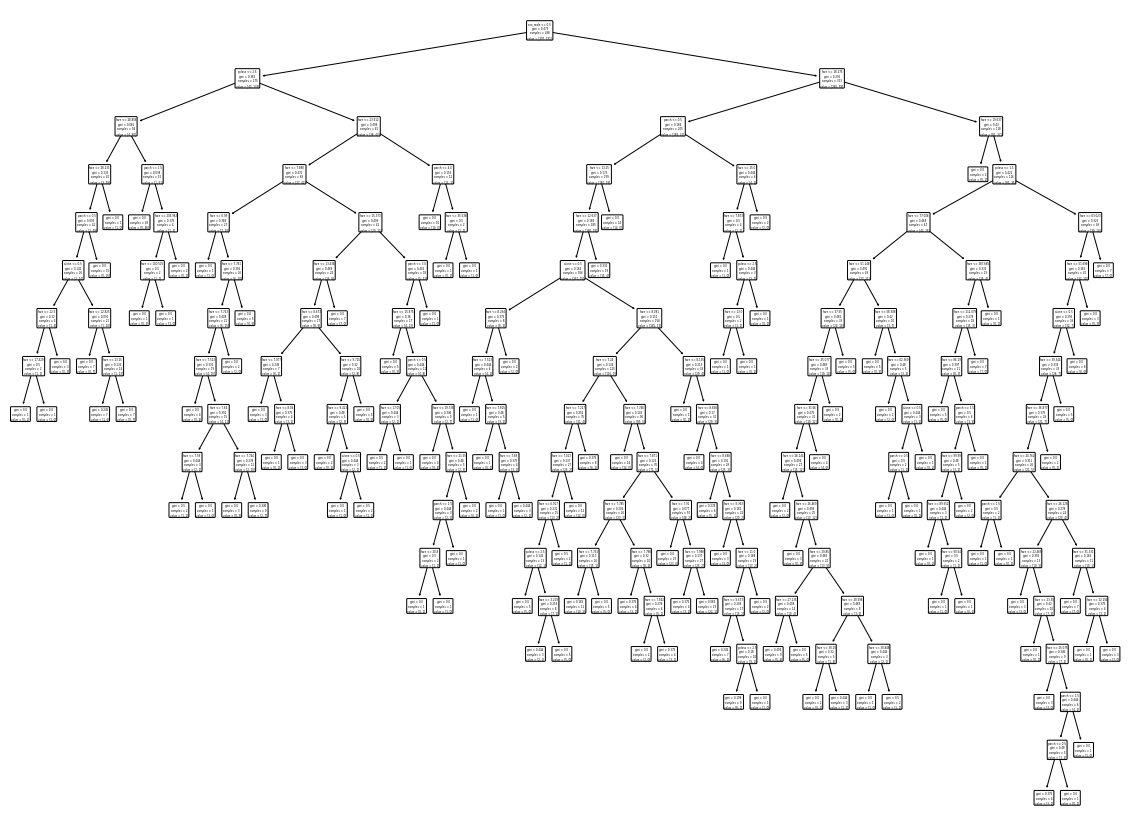

In [67]:
plt.figure(figsize = (20, 15))
plot_tree(clf, feature_names = X_train.columns, rounded = True)


### 4). Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [68]:
conf

array([[303,   4],
       [ 26, 165]])

In [69]:
# Convert confusion matric into table (legibility)

conf_df = pd.DataFrame(conf, columns = ['predict_death', 'predict_survival'],
                       index = ['actual_death', 'actual_survival'])

conf_df

,predict_death,predict_survival
actual_death,303,4
actual_survival,26,165


In [70]:
# key for reference

rubric_df = pd.DataFrame([['true negative', 'false positive'],
                          ['false negative', 'true positive']], 
                         columns=['predict_death', 'predict_survive'], 
                         index=['actual_death', 'actual_survive']
                        )

rubric_df

,predict_death,predict_survive
actual_death,true negative,false positive
actual_survive,false negative,true positive


In [71]:
# Concat tables

conf_rubric = pd.concat([conf, rubric_df], axis = 1)

rubric_df + ': '+ conf_df.values.astype(str)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

### 5). Run through steps 2-4 using a different max_depth value.


In [ ]:
clf_dept_2 = DecisionTreeClassifier(max_depth = 2)
clf_dept_2

In [ ]:
# fit Model

clf_dept_2.fit(X_train, y_train)

In [ ]:
y_pred = clf_dept_2.predict(X_train)
y_pred 

In [ ]:
# Model Accuracy
accuracy = clf_dept_2.score(X_train, y_train)
print(f'\n\tModel with max_dept ==2 accuracy: {accuracy:,.3%}')
print()

### 6). Which model performs better on your in-sample data?


In [ ]:
# Model II Accuracy
accuracy = clf_dept_2.score(X, y)

# Model Predictions
y_pred = clf_dept_2.predict(X)

y_prediction = clf_dept_2.predict(y, y_pred)

# Classification Report (sklearn.metrics)
class_report = pd.DataFrame(classification_report(y, y_pred, output_dict = True)).T

# Using Confusion matrix to compute data
conf = confusion_matrix(y, y_pred)
tpr = conf[1][1] / conf[1].sum()
fpr = conf[0][1] / conf[0].sum()
tnr = conf[0][0] / conf[0].sum()
fnr = conf[1][0] / conf[1].sum()

print()
print(f'''  Accuracy: {accuracy:.4%}

            True +ve: {tpr:.3%}
            
            False +ve: {fpr:.3%}
            
            True -ve: {tnr:.3%}
            
            False -ve: {fnr:.3%}
            
        '''
     )

class_report

### 7). Which model performs best on your out-of-sample data, the validate set?


In [ ]:
# Model I (max_depth = 3)

y_val_pred_1 = clf.score(validate.drop(columns = 'survived'), validate.survived)

# Model II (max_depth = 2)
y_val_pred_2 = clf_dept_2.score(validate.drop(columns = 'survived'), validate.survived)


print(f'''

        Model I : {y_val_pred_1: ,.3%}
        
        Model II : {y_val_pred_2: ,.3%}


''')

In [ ]:
# Model I graph

dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data)

In [ ]:
graph.render('titanic_model_1_tree', view=True)


In [ ]:
# Model II graph

dot_data = export_graphviz(clf_dept_2, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data)

In [ ]:
graph.render('titanic_model_2_tree', view=True)


> # Part II

>## (B). Random Forest Exercises
>

### 1). Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [ ]:
train, validate, test = train_validate_test_split(titanic, target = 'survived')
train.shape, validate.shape, test.shape

In [ ]:
train

In [ ]:
# Drop unnecesary columns 

col_to_drops = ['passenger_id', 'sibsp', 'class', 'embarked', 
                'sex','embark_town','se_male', 'embark_town_Queenstown',
               'embark_town_Southampton', 'deck'
               ]

[titanic_data.drop(columns = col_to_drops, inplace = True, errors = 'ignore') for titanic_data in [train, validate, test]]

train.head()

In [ ]:
X_train, y_train = train.drop(columns='survived'), train[['survived']]


### 2). Evaluate your results using the model score, confusion matrix, and classification report.



### 3). Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

### 4). Run through steps increasing your min_samples_leaf and decreasing your max_depth.



### 5). What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

> # Part III

> ##  (C). K - Nearest Neighbor Exercises (KNN)
>

In [99]:
# Call the data
titanic = acquire.get_titanic_data()
titanic.head()

# Prepare & Split data into train, validate and test
titanic = prep_titanic(titanic)

def train_validate_test_split(titanic, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(titanic, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=titanic[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

## Call split function and split the data
train, validate, test = train_validate_test_split(titanic, target = 'survived')
train.shape, validate.shape, test.shape

((498, 10), (214, 10), (179, 10))

In [100]:
# Call impute function to fill in missing values

train, validate, test = impute_mode(train, validate, test)

In [101]:
# Drop unnecesary columns 

col_to_drops = ['passenger_id', 'sibsp', 'class', 'embarked', 
                'sex','embark_town','se_male', 'embark_town_Queenstown',
               'embark_town_Southampton', 'sex_male', 'alone', 'parch'
               ]

[titanic_data.drop(columns = col_to_drops, inplace = True, errors = 'ignore') for titanic_data in [train, validate, test]]

train.head()

,survived,pclass,fare
583,0,1,40.1250
165,1,3,20.5250
50,0,3,39.6875
259,1,2,26.0000
306,1,1,110.8833


In [102]:
train.shape, validate.shape, test.shape

((498, 3), (214, 3), (179, 3))

### 1). Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

In [103]:
# split into train, validate, test
# train, validate, test = train_validate_test_split(titanic, target='survived', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['survived'])
y_train = train[['survived']]

X_validate = validate.drop(columns=['survived'])
y_validate = validate[['survived']]

X_test = test.drop(columns=['survived'])
y_test = test[['survived']]


In [104]:
X_train, y_train = train.drop(columns = 'survived'), train[['survived']]

In [105]:
X_train.head()

,pclass,fare
583,1,40.1250
165,3,20.5250
50,3,39.6875
259,2,26.0000
306,1,110.8833


In [106]:
# from sklearn.impute import SimpleImputer


# imputer = SimpleImputer(strategy = 'most_frequent', missing_values = np.nan)

# imputer = imputer.fit(train[['survived']])

# train[['survived']] = imputer.transform(test[['survived']])



In [107]:
# Impute the data for missing values (train, validate, test)

# train, validate, test = prepare.impute_mode(train, validate, test)


In [108]:
train.head() 

,survived,pclass,fare
583,0,1,40.1250
165,1,3,20.5250
50,0,3,39.6875
259,1,2,26.0000
306,1,1,110.8833


> ##### Create & fit to nearest neighbor
>

In [109]:
# Create and Fit the model

knn = KNN(n_neighbors = 5, weights = 'uniform')

# Fit

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [110]:
# Make predictions

y_pred = knn.predict(X_train)
y_pred

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [111]:
# Estimate probability of pclass

y_pred_proba = knn.predict_proba(X_train)
y_pred_proba.T

array([[0.4, 0.6, 0.8, 0.6, 0.4, 0.6, 0.4, 0.6, 0.8, 1. , 0.6, 0.6, 0. ,
        1. , 0.2, 0.8, 0.8, 0.4, 0.8, 1. , 0.4, 0.8, 0.2, 0.4, 0.6, 1. ,
        0. , 1. , 0.4, 0.8, 1. , 0.6, 1. , 0. , 0.6, 0.6, 0.8, 0.4, 0.6,
        0. , 1. , 1. , 0.6, 0.6, 0.6, 1. , 0.8, 0.8, 0.8, 0.4, 1. , 0.6,
        0.2, 0.6, 0.8, 0.2, 1. , 0.8, 0.8, 0.8, 1. , 1. , 1. , 0.8, 0.8,
        0.8, 0.4, 0.8, 0.6, 0.6, 0.8, 1. , 0.6, 0.4, 0.8, 0.8, 0.8, 0.8,
        0.8, 0.6, 0.6, 0.4, 0.8, 0.8, 0.8, 0.4, 0.4, 0.6, 0.4, 0.8, 1. ,
        0.8, 0.4, 0.4, 0.8, 0.6, 0.4, 0.4, 0.4, 0.4, 1. , 0.4, 0.4, 1. ,
        0.4, 0. , 0.6, 0. , 1. , 1. , 0.2, 0.2, 0.8, 1. , 0.8, 0.6, 1. ,
        1. , 0.4, 0.4, 1. , 0.8, 0.4, 0.6, 0.6, 0.6, 0. , 0.4, 0.8, 0.8,
        0.4, 1. , 0.6, 0.6, 0.8, 1. , 0.6, 0.8, 0.6, 0.4, 0.4, 0.4, 0.6,
        0.8, 0.2, 0.6, 0.6, 0.6, 0.2, 0.6, 1. , 0.6, 0.8, 1. , 1. , 0. ,
        0.6, 0.8, 0.4, 0.8, 0.6, 0.8, 0.6, 0.8, 1. , 1. , 0.6, 1. , 0.6,
        0.8, 0.6, 0.4, 0.4, 0.6, 0.4, 0.4, 0.2, 0.4

> ##### Create scaller
>


In [112]:

myscaler = MinMaxScaler()

In [113]:
# Fit the X_train

myscaler.fit(X_train)

MinMaxScaler()

In [114]:
# Transform the fitted scaller

scaled_values = myscaler.transform(X_train)
scaled_values

array([[0.        , 0.07831878],
       [1.        , 0.04006213],
       [1.        , 0.07746484],
       [0.5       , 0.05074862],
       [0.        , 0.21642979],
       [0.5       , 0.04684488],
       [0.5       , 0.05123659],
       [0.5       , 0.02049464],
       [1.        , 0.01512699],
       [1.        , 0.13575256],
       [1.        , 0.03945217],
       [0.        , 0.05182215],
       [0.5       , 0.03806147],
       [0.        , 0.0556283 ],
       [0.5       , 0.05270049],
       [1.        , 0.01571255],
       [1.        , 0.01571255],
       [1.        , 0.01537917],
       [0.5       , 0.02537431],
       [1.        , 0.01546857],
       [1.        , 0.02173075],
       [1.        , 0.01517579],
       [0.        , 0.16883676],
       [0.        , 0.12999454],
       [0.        , 0.05182215],
       [1.        , 0.01541158],
       [0.5       , 0.05869429],
       [0.        , 0.05604307],
       [0.        , 0.05060223],
       [0.5       , 0.02537431],
       [1.

In [115]:
scaled_cols = [col + '_scaled' for col in X_train.columns]
scaled_cols

['pclass_scaled', 'fare_scaled']

In [116]:
X_train[scaled_cols] = scaled_values

X_train.head()

,pclass,fare,pclass_scaled,fare_scaled
583,1,40.1250,0.0,0.078319
165,3,20.5250,1.0,0.040062
50,3,39.6875,1.0,0.077465
259,2,26.0000,0.5,0.050749
306,1,110.8833,0.0,0.216430


In [117]:
sns.scatterplot(data = X_train, x = 'fare_scaled', y = 'age_scaled', hue = 'age')

ValueError: Could not interpret value `age_scaled` for parameter `y`

In [118]:
clf = KNN(n_neighbors = 4, weights = 'uniform')


clf.fit(X_train, y_train)

cols = ['fare_scaled', 'age_scaled', 'pclass_scaled']

clf.fit(X_train[cols], y_train['survived'])

KeyError: "['age_scaled'] not in index"

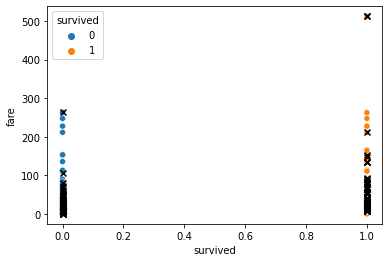

In [119]:
sns.scatterplot(data = train, x = 'survived', y = 'fare', hue = 'survived')
plt.scatter(validate.survived, validate.fare, marker ='x', c = 'black')
plt.show()

### 2). Evaluate your results using the model score, confusion matrix, and classification report.



In [120]:
knn = KNN(n_neighbors = 5, weights='uniform')


In [121]:
# Fit the model

knn.fit(X_train, y_train)

KNeighborsClassifier()

> #####  Computed Accuracy 
>

In [122]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.74


> ##### Confusion Matrix
>

In [123]:
print(confusion_matrix(y_train, y_pred))


[[265  42]
 [ 87 104]]


> ##### Classification Report
>

In [124]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.86      0.80       307
           1       0.71      0.54      0.62       191

    accuracy                           0.74       498
   macro avg       0.73      0.70      0.71       498
weighted avg       0.74      0.74      0.73       498



### 3). Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

### 4). Run through steps 2-4 setting k to 10



In [125]:
knn = KNN(n_neighbors = 10, weights='uniform')

knn.fit(X_train, y_train)


print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))


Accuracy of KNN classifier on training set: 0.71


In [126]:
print(confusion_matrix(y_train, y_pred))


[[265  42]
 [ 87 104]]


In [127]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.86      0.80       307
           1       0.71      0.54      0.62       191

    accuracy                           0.74       498
   macro avg       0.73      0.70      0.71       498
weighted avg       0.74      0.74      0.73       498



### 5). Run through setps 2-4 setting k to 20



In [128]:
knn = KNN(n_neighbors = 20, weights='uniform')

knn.fit(X_train, y_train)


print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.68


In [129]:
print(confusion_matrix(y_train, y_pred))


[[265  42]
 [ 87 104]]


In [130]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.86      0.80       307
           1       0.71      0.54      0.62       191

    accuracy                           0.74       498
   macro avg       0.73      0.70      0.71       498
weighted avg       0.74      0.74      0.73       498



### 6). What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

>> **Best model (KNeighbor = 5) = 74%**

### 7). Which model performs best on our out-of-sample data from validate?



In [131]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))


ValueError: X has 2 features, but KNeighborsClassifier is expecting 4 features as input.

In [132]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNN(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

ValueError: X has 2 features, but KNeighborsClassifier is expecting 4 features as input.

> # Part IV

> ## (D). Logistic Regression Exercises
>

__NOTE:__ -  Choose a model that optimizes for accuracy

-----------------------------------------------
-    Logistic Regression (aka logit, MaxEnt) classifier.



In [121]:
titanic = acquire.get_titanic_data()
titanic.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


#### Encode sex into 1 for male and 0 for female

> #### Male == 0
> #### Female == 1



In [122]:
titanic['sex'] = np.where(titanic.sex == 'male', '0', '1')

In [123]:

## Call split function and split the data
train, validate, test = train_validate_test_split(titanic, target = 'survived')

print(f'''
            Train Shape: {train.shape}
            
            Validate Shape: {validate.shape}
            
            Test Shape:  {test.shape}
            
        ''')


            Train Shape: (498, 13)
            
            Validate Shape: (214, 13)
            
            Test Shape:  (179, 13)
            
        


In [124]:
# Drop unnecesary columns 

col_to_drops = ['passenger_id','parch', 'embarked', 'class',
                'deck','embark_town','sibsp'
               ]

[titanic_data.drop(columns = col_to_drops, inplace = True, errors = 'ignore') 
for titanic_data in [train, validate, test]]

train.head()

,survived,pclass,sex,age,fare,alone
583,0,1,0,36.0,40.1250,1
165,1,3,0,9.0,20.5250,0
50,0,3,0,7.0,39.6875,0
259,1,2,1,50.0,26.0000,0
306,1,1,1,NaN,110.8833,1


In [125]:
train.columns

Index(['survived', 'pclass', 'sex', 'age', 'fare', 'alone'], dtype='object')

In [126]:
train.sex.value_counts()

0    323
1    175
Name: sex, dtype: int64

> #### Impute transfomer for completing missing values.


In [127]:
train, validate, test = impute_mode(train, validate, test)

### 1). Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?



In [128]:
# split into train, validate, test
train, validate, test = train_validate_test_split(train, target='survived', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['age','fare', 'pclass'])
y_train = train.survived

X_validate = validate.drop(columns=['age','fare', 'pclass'])
y_validate = validate.survived

X_test = test.drop(columns=['age','fare', 'pclass'])
y_test = test.survived

> #### Create a model

In [129]:

logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')
logit

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

> #### Fit the model

In [130]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

>#### Feature Importance

In [131]:
print('\n\tModel Coefficient: ', logit.coef_)
print()
print('\n\tModel Intercept: ', logit.intercept_)
print()


	Model Coefficient:  [[ 9.47937164  1.0539182  -0.13598996]]


	Model Intercept:  [-2.9611326]



> #### Make Predictions

>>-  Whether survived with fare, age, pclass

In [132]:
y_pred = logit.predict(X_train)

y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])

> #### Estimate Probability 
>>-  Whether survived for age, pclass and fare

In [133]:
y_pred_proba = logit.predict_proba(X_train)
y_pred_proba.T

array([[9.56773897e-01, 9.56773897e-01, 9.56773897e-01, 9.56773897e-01,
        9.50787016e-01, 9.56773897e-01, 9.56773897e-01, 5.14316514e-04,
        9.56773897e-01, 9.56773897e-01, 9.56773897e-01, 8.70705876e-01,
        8.85259154e-01, 9.50787016e-01, 9.56773897e-01, 5.89193060e-04,
        9.56773897e-01, 1.68845905e-03, 9.56773897e-01, 5.14316514e-04,
        8.85259154e-01, 9.50787016e-01, 8.70705876e-01, 9.56773897e-01,
        9.50787016e-01, 9.56773897e-01, 5.14316514e-04, 5.14316514e-04,
        9.50787016e-01, 9.56773897e-01, 9.56773897e-01, 9.56773897e-01,
        9.50787016e-01, 9.50787016e-01, 1.68845905e-03, 9.50787016e-01,
        8.85259154e-01, 9.56773897e-01, 9.56773897e-01, 5.89193060e-04,
        9.56773897e-01, 9.56773897e-01, 9.50787016e-01, 5.14316514e-04,
        1.47409030e-03, 5.14316514e-04, 9.56773897e-01, 9.50787016e-01,
        9.56773897e-01, 1.68845905e-03, 5.14316514e-04, 5.89193060e-04,
        9.56773897e-01, 5.89193060e-04, 8.70705876e-01, 8.852591

> #### Compute Accuracy
>

In [134]:
print('Accuracy of Logistic Regression classifier I on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))


Accuracy of Logistic Regression classifier I on training set: 1.00


> #### Confusion Matrix
>

In [135]:
print(confusion_matrix(y_train, y_pred))

[[171   0]
 [  0 107]]


> #### Classification Report


In [136]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       1.00      1.00      1.00       107

    accuracy                           1.00       278
   macro avg       1.00      1.00      1.00       278
weighted avg       1.00      1.00      1.00       278



### 2). Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.

#### Encode sex into 1 for male and 0 for female

> #### Male == 0
> #### Female == 1



In [137]:
# split into train, validate, test
train, validate, test = train_validate_test_split(train, target='survived', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train2 = train.drop(columns=['age','fare', 'pclass', 'sex'])
y_train2 = train.survived

X_validate2 = validate.drop(columns=['age','fare', 'pclass', 'sex'])
y_validate2 = validate.survived

X_test2 = test.drop(columns=['age','fare', 'pclass', 'sex'])

In [138]:
# Create model
logit2 = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')


# Fit model
logit2.fit(X_train2, y_train2)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

In [139]:
# Feature Importance

print('\n\tModel Coefficient: ', logit2.coef_)
print()
print('\n\tModel Intercept: ', logit2.intercept_)
print()


	Model Coefficient:  [[ 8.77705627 -0.23000182]]


	Model Intercept:  [-2.14294968]



In [140]:
# Make predictions

y_pred2 = logit2.predict(X_train2)

y_pred2

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0])

In [141]:
# Estimate probability

y_pred_proba2 = logit2.predict_proba(X_train2)
y_pred_proba2.T

array([[0.91474133, 0.89500811, 0.00165202, 0.89500811, 0.89500811,
        0.91474133, 0.91474133, 0.91474133, 0.00165202, 0.00165202,
        0.00131303, 0.00131303, 0.89500811, 0.91474133, 0.00165202,
        0.89500811, 0.00131303, 0.00131303, 0.00131303, 0.91474133,
        0.00165202, 0.00165202, 0.89500811, 0.00165202, 0.91474133,
        0.91474133, 0.91474133, 0.89500811, 0.91474133, 0.89500811,
        0.91474133, 0.00165202, 0.89500811, 0.89500811, 0.00131303,
        0.91474133, 0.91474133, 0.91474133, 0.91474133, 0.00165202,
        0.91474133, 0.91474133, 0.00131303, 0.91474133, 0.91474133,
        0.89500811, 0.00131303, 0.00165202, 0.00165202, 0.89500811,
        0.91474133, 0.91474133, 0.91474133, 0.91474133, 0.91474133,
        0.89500811, 0.00165202, 0.00165202, 0.00131303, 0.00165202,
        0.89500811, 0.91474133, 0.00131303, 0.89500811, 0.00131303,
        0.91474133, 0.91474133, 0.89500811, 0.91474133, 0.91474133,
        0.91474133, 0.00131303, 0.00165202, 0.00

In [142]:
print('Accuracy of Logistic Regression classifier II on training set: {:.2f}'
     .format(logit2.score(X_train2, y_train2)))


Accuracy of Logistic Regression classifier II on training set: 1.00


In [143]:
# Confusion Matrix

print(confusion_matrix(y_train2, y_pred2))

[[96  0]
 [ 0 59]]


In [144]:
# Classification Matrix

print(classification_report(y_train2, y_pred2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00        59

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155
weighted avg       1.00      1.00      1.00       155



### 3). Try out other combinations of features and models.


-  Survival based on features: __'Age'__ | __'alone'__ | __'pclass'__ | __'sex'__


In [147]:
# split into train, validate, test
train, validate, test = train_validate_test_split(train, target='survived', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train3 = train.drop(columns=['age','pclass', 'alone', 'sex'])
y_train3 = train.survived

X_validate3 = validate.drop(columns=['age','pclass', 'alone', 'sex'])
y_validate3 = validate.survived

X_test3 = test.drop(columns=['age','pclass', 'alone', 'sex'])

In [148]:
# Create model
logit3 = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')


# Fit model
logit3.fit(X_train3, y_train3)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

In [149]:
# Feature Importance

print('\n\tModel Coefficient: ', logit3.coef_)
print()
print('\n\tModel Intercept: ', logit3.intercept_)
print()


	Model Coefficient:  [[5.52130075 0.01410337]]


	Model Intercept:  [-0.94654383]



In [150]:
# Make predictions

y_pred3 = logit3.predict(X_train3)

y_pred3

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1])

In [151]:
# Estimate probability

y_pred_proba3 = logit3.predict_proba(X_train3)
y_pred_proba3.T

array([[8.93557566e-03, 4.53015232e-03, 4.77501659e-01, 6.82048078e-01,
        3.36235997e-03, 6.96991355e-01, 4.16325331e-04, 6.97574238e-01,
        6.96991355e-01, 6.97884176e-01, 6.77583989e-01, 8.50887064e-03,
        9.22369537e-03, 7.09359146e-03, 6.41034295e-01, 6.96991355e-01,
        6.28940357e-01, 7.20419584e-01, 6.13426953e-01, 4.77501659e-01,
        6.92392364e-01, 6.82048078e-01, 6.99368889e-01, 8.81154105e-03,
        4.88860128e-03],
       [9.91064424e-01, 9.95469848e-01, 5.22498341e-01, 3.17951922e-01,
        9.96637640e-01, 3.03008645e-01, 9.99583675e-01, 3.02425762e-01,
        3.03008645e-01, 3.02115824e-01, 3.22416011e-01, 9.91491129e-01,
        9.90776305e-01, 9.92906409e-01, 3.58965705e-01, 3.03008645e-01,
        3.71059643e-01, 2.79580416e-01, 3.86573047e-01, 5.22498341e-01,
        3.07607636e-01, 3.17951922e-01, 3.00631111e-01, 9.91188459e-01,
        9.95111399e-01]])

In [152]:
print('Accuracy of Logistic Regression classifier III on training set: {:.2f}'
     .format(logit3.score(X_train3, y_train3)))


Accuracy of Logistic Regression classifier III on training set: 0.92


In [154]:
# Confusion Matrix

print(confusion_matrix(y_train3, y_pred3))

[[14  2]
 [ 0  9]]


In [155]:
print(classification_report(y_train3, y_pred3))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.82      1.00      0.90         9

    accuracy                           0.92        25
   macro avg       0.91      0.94      0.92        25
weighted avg       0.93      0.92      0.92        25



### 4). Use you best 3 models to predict and evaluate on your validate sample.



In [181]:
# make predictions

y_pred = logit.predict(X_validate)
y_pred2 = logit2.predict(X_validate2)
y_pred3 = logit3.predict(X_validate3)



print("Model 1: solver = lbfgs, c = 1")

# accuracy of model 1
print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

# confusion matrix of model 1
print(confusion_matrix(y_validate, y_pred))

# classification report of model 1
print(classification_report(y_validate, y_pred))

print('-------------------------------------------------------------------')
print()

print("Model 2: solver = lbfgs, c = .1")

# accuracy of model 2
print('Accuracy: {:.2f}'.format(logit2.score(X_validate2, y_validate2)))


print()
# confusion matrix of model 2
print(confusion_matrix(y_validate2, y_pred2))

# classification report of model 2
print(classification_report(y_validate2, y_pred2))


print('-------------------------------------------------------------------')
print()

print("Model 3: solver = lbfgs, c = .1")

# accuracy of model 3
print('Accuracy: {:.2f}'.format(logit3.score(X_validate3, y_validate3)))

# confusion matrix of model 3
print(confusion_matrix(y_validate3, y_pred3))

# classification report of model 3
print(classification_report(y_validate3, y_pred3))




Model 1: solver = lbfgs, c = 1
Accuracy: 1.00
[[74  0]
 [ 0 46]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00        46

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

-------------------------------------------------------------------

Model 2: solver = lbfgs, c = .1
Accuracy: 1.00

[[24  0]
 [ 0 14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        14

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

-------------------------------------------------------------------

Model 3: solver = lbfgs, c = .1
Accuracy: 0.92
[[6 1]
 [0 5]]
              

### 5). Choose you best model from the validation performation, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?

-  Model I has best accuracy on a large support

In [182]:
y_pred = logit.predict(X_test)
y_pred_proba = logit.predict_proba(X_test)

print("Model 1: solver = lbfgs, c = 1")

print('Accuracy: {:.2f}'.format(logit.score(X_test, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))


Model 1: solver = lbfgs, c = 1
Accuracy: 1.00
[[62  0]
 [ 0 38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        38

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



> #### Visualize Model
> 

In [183]:
# create array of probabilities of being versicolor (versicolor == 1)

y_pred_proba = np.array([i[1] for i in y_pred_proba])


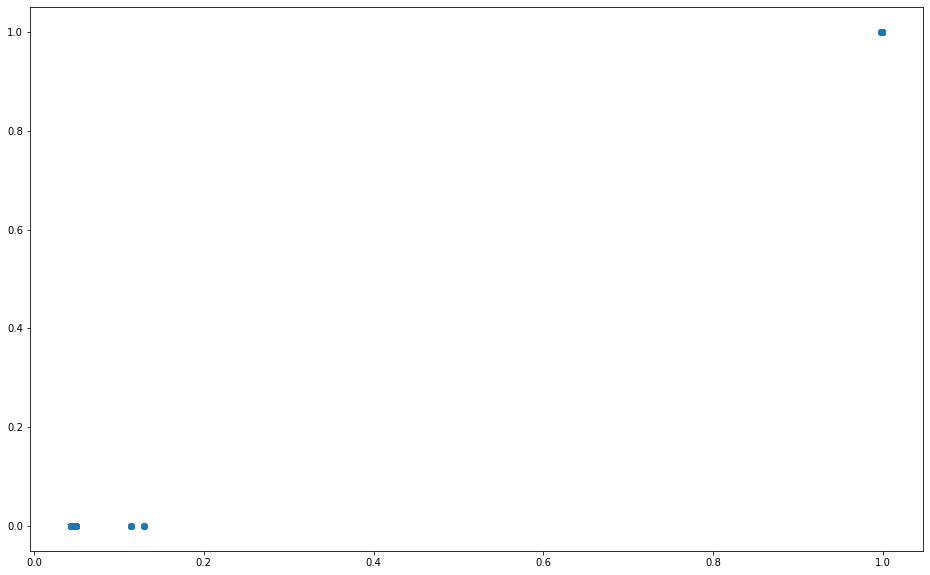

In [186]:
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)

# scatter plot where x is the probabilities and y is the class (0, 1)
ax.scatter(y_pred_proba, y_pred)
